# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [1]:
# Sólo necesario en caso de correr en Google Colab conectado a Drive
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Neural Style Transfer')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from tensorflow.compat.v1 import disable_eager_execution, enable_eager_execution, ConfigProto, Session
from pathlib import Path

from IPython.display import Image, display
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# Imagen para estilo
!wget 'https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg'

# Imagen para contenido
!wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg'

# Creamos el directorio para los archivos de salida
!mkdir /output

--2021-01-21 22:01:54--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.2’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.08s   

2021-01-21 22:01:55 (2.83 MB/s) - ‘La_noche_estrellada1.jpg.2’ saved [223725/223725]

--2021-01-21 22:01:55--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) [ima

In [4]:
# Se necesita desactivar "Eager Execution" para evitar un error al obtener los gradientes
# (Punto 5, última celda - K.gradients no es compatible con eager execution)

# enable_eager_execution()
disable_eager_execution()

# Al desactivar Eager Execution, el Punto 7 arroja un error de OOM (memoria)
# Se puede solucionar permitiendo a Tensorflow alocar memoria en lla GPU a medida que vaya
# siendo necesario, pero depende de la cantidad total de vram disponible
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

# Alternativamente, utilizar Tensorflow con CPU

In [5]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida
base_image_path = Path("./775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("./La_noche_estrellada1.jpg")
result_prefix = Path("./output")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:
* total_variation_weight ($\lambda_{TV}$): coeficiente de ajuste del efecto de suavizado (regularización) que aplica la total_variation_loss sobre la imagen generada.
* content_wieght ($\alpha$) = coeficiente de énfasis de la reconstrucción del contenido.<br>
* style_weight ($\beta$) = coeficiente de énfasis de la reconstrucción del estilo.


In [6]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [7]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:<br>

La celda contiene el código de una función diseñada para adaptar el input de una imagen a un formato adecuado para la arquitectura VGG19. Pasándole la ruta de una imagen, realiza las siguientes acciones:<br>
* **load_img(image_path, target_size=(img_nrows, img_ncols))** -> Carga la imagen a partir de la ruta proporcionada con el tamaño indicado.

* **img_to_array(img)** -> Transforma la imagen (PIL) en un numpy array 3D (Tensor) de shape (alto, ancho, canales).

* **np.expand_dims(img, axis=0)** -> Toma el Tensor generado y agrega una dimensión adicional para indicar el número de samples (o imágenes) en el batch, generando un Tensor con 4 dimensiones (n_samples, alto, ancho, canales).

* **vgg19.preprocess_input(img)** -> Toma el Tensor de 4D y lo separa en batches adecuándolo al formato requerido por la VGG19. Convierte el formato RGB en BGR centrado en cero con respecto a la media por píxel del dataset de ImageNet sin scaling.

* Finalmente devuelve la imagen preprocesada con el formato adecuado (Tensor 4D)  para entrar a la VGG19.

In [8]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

Esta función revierte la transformación realizada por la función _preprocess_image()_  para adaptar la imagen al formato de la VGG19, primero removiendo el centrado en cero con respecto a la media por píxel y luego convirtiendo el formato de la imagen nuevamente a RGB.<br>
Finalmente, devuelve la imagen deprocesada.

In [9]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [11]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [12]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [13]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?

La matriz de Gram ($G^{l}$) es una representación del estilo de una imagen que computa las correlaciones entre las diferentes respuestas de los filtros de las capas convolucionales (features). Se obtiene realizando el producto punto entre el mapa de activaciones convolucionales de profundidad C (donde C equivale a la cantidad de canales) vectorizado a través de un _flatten_ ($F^{l}_{ik}$) y su traspuesto ($F^{l}_{jk}$), dando por resultado una matriz de tamaño CxC:

$$G^{l}_{ij}=\sum\limits_{k}F^{l}_{ik}F^{l}_{jk}$$<br>

El producto punto entre los vectores brinda la información acerca de la relación entre ambos, donde a menor producto existe una menor co-ocurrencia de dos features, mientras que cuanto mayor sea aquel más tenderán dos features a ocurrir conjuntamente.

La matriz de Gram se utiliza para computar el Descenso de Gradiente desde una imagen de ruido blanco hasta alcanzar otra que coincida con la representación del estilo de la imagen original. De esta manera, se computa la matriz de Gram para la imagen original de la cual se desea capturar el estilo y para una imagen output (inicializada como ruido blanco) y se minimiza el MSE entre ambas.

- ¿Por qué se permutan las dimensiones de x?

Las dimensiones de x se permutan de manera tal de adaptar la forma original del tensor _(alto, ancho, canales)_ a una que permita obtener una matriz con forma CxC, es decir con un _shape = (canales, canales)_. Para ello, se realizan los siguientes pasos:

1. Se permutan las dimensiones del tensor a través de la función **_permute_dimensions_** del backend de Keras, que lo transforma a la forma indicada en el argumento _'pattern'_ (recibe una tupla con la nueva posición los índices de los valores del input_shape). Donde originalmente el tensor adquiere la forma (alto, ancho, canales), pasando la tupla (2, 0, 1) a este argumento de dicha función, se lo transforma para que adquiera la forma **_(canales, alto, ancho)_**.

2. Una vez permutadas las dimensiones, se realiza un **_batch_flatten_** que permite obtener un vector de dimensión (canales, alto * ancho).

3. Se realiza el producto punto entre el vector anterior y su forma traspuesta, obteniendo como resultado una matriz de forma CxC (canales, canales) que finalmente es devuelta por la función _'gram_matrix'_.

In [14]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:

La técnica de Neural Style Transfer se vale de dos Loss Functions y un término de regularización que se minimizan en conjunto a través del proceso de backpropagation para capturar el contenido de la imagen original (a través de la _Content Loss_) y el estilo artístico de otra (a través de la _Style Loss_) y lograr reflejarlo en el output de forma combinada.<br>
<br>
En esencia, a medida que una imagen $\overrightarrow{x}$ va pasando por las sucesivas capas de una CNN, se van almacenando las respuestas en una matriz $F^{l}\in\mathcal{R}^{N_{l}xM_{l}}$, donde $N_{l}$ simboliza el número de filtros en la capa _l_ y $M_{l}$ el tamaño de cada filtro (alto x ancho). Por lo tanto, cada activación en esta matriz se simboliza como $F^{l}_{ij}$, entendida como la activación del filtro $i^{esimo}$ en la posición _j_ pertenecientes a la capa _l_.<br> 

Durante el proceso de backpropagation, las losses mencionadas se van calculando y minimizando de la siguiente manera:

**Style Loss**


En líneas generales, al alimentar la CNN con una imagen que contenga el estilo artístico deseado y una imagen de entrada, esta devolverá los outputs de las capas intermedias del modelo. Sin embargo, para el cómputo de la Style Loss, la técnica de Neural Style Transfer se vale de las matrices de Gram. En lugar de comparar dichos outputs tal cual resultan de la aplicación de los filtros convolucionales, se comparan sus matrices de Gram.

En términos matemáticos, se puede describir la Style Loss de una imagen de entrada ($\overrightarrow{x}$) y la de estilo ($\overrightarrow{a}$) como la distancia cuadrática media entre la representación del estilo (capturada en la matriz de Gram) de cada una de ellas. La representación del estilo de una imagen puede describirse como la correlación entre las diferentes respuestas de los filtros capturada en la matriz de Gram $G^{l}$, donde $G^{l}_{ij}$ es el producto punto entre los mapas de activación vectorizados _i_ y _j_ en la capa _l_. De esta manera, se puede observar que $G^{l}_{ij}$ representa la correlación entre estos dos mapas de activación.

Para replicar el estilo artístico de la imagen de estilo en la imagen de entrada, es necesario realizar gradient descent con el objetivo de transformar la imagen de entrada en una cuya representación de estilo coincida con la imagen de estilo original.

La contribución de cada capa a la Style Loss total se puede describir como:
$$
\begin{equation}
E_{l} = \frac{1}{4N^{2}_{l}M^{2}{l}}\sum\limits_{i,j}(G^{l}_{ij} - A^{l}_{ij})^{2}
\end{equation}
$$
donde $G^{l}_{ij}$ y $A^{l}_{ij}$ son las respectivas representaciones de estilo en la capa _l_ de la imagen de entrada $\overrightarrow{x}$ y la imagen de estilo $\overrightarrow{a}$. $N_{l}$ describe el número de mapas de activación, cada uno de tamaño $M_{l}$ = alto x ancho. De esta manera, la Style Loss total a través de cada una de las capas de la red es:

$$
\begin{equation}
\mathcal{L}_{style}(\overrightarrow{a},\overrightarrow{x}) = \sum\limits^{L}_{l=0}w_{l}E_{l}
\end{equation}
$$

donde $w_{l}$ factores de ponderación de la contibución de cada capa _l_ a la loss total. De acuerdo a los autores del paper, $w_{l}$ equivale, en todos los casos, a:

$$
\begin{equation}
w_{l}=\frac{1}{{\|L\|}}
\end{equation}
$$

siendo $\|L\|$ el número de capas activas con un factor de ponderación $w_{l}$ distinto de cero.

Para realizar gradient descent, computado usando backpropagation, se calcula la derivada parcial de $E_{l}$ con respecto a las activaciones en la capa _l_ de la siguiente forma:

$$
\begin{equation}
\frac{\partial{E_{l}}}{\partial{F^{l}_{ij}}} = 
    \begin{cases}
        {\frac{1}{N^{2}_{l}M^{2}{l}}((F^{l})^{T} (G^{l} - A^{l}))} & if & F^{l}_{ij} > 0 \\
        {0} & if & F^{l}_{ij} < 0
    \end{cases}
\end{equation}
$$

<br>

En la celda de abajo puede observarse el cálculo de $E_{l}$ dada _style_ (imagen de estilo $\overrightarrow{a}$) y _combination_ (imagen de entrada $\overrightarrow{x}$), calculando primero las matrices de Gram de cada una de ellas con la función gram\_matrix() implementada anteriormente, luego definiendo la cantidad de canales ($N_{l}$) y su tamaño ($M_{l}$) en base a las dimensiones de las imágenes y devolviendo el cálculo de la fórmula descripta anteriormente para $E_{l}$. Más abajo se expresa el cálculo completo de $\mathcal{L}_{style}$.

In [15]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**Content Loss**


La Content Loss sigue un principio similar a la Style Loss sólo que, en lugar de emplear matrices de Gram, simplemente se calcula la distancia euclideana entre las dos representaciones de una imagen de entrada y otra con el contenido que se desea replicar.

Formalmente, la Content Loss es una función que describe la distancia entre el contenido de una imagen de entrada $\overrightarrow{x}$ y la imagen con el contenido original $\overrightarrow{p}$. Considerando $F^{l}$ y $P^{l}$ como las respectivas representaciones de features de la capa _l_, es posible definir la función como el error cuadrático entre ambas:

$$
\begin{equation}
\mathcal{L}_{content}(\overrightarrow{p},\overrightarrow{x},l) = \sum\limits_{i,j}(F^{l}_{ij} - P^{l}_{ij})^2 
\end{equation}
$$

Se computa el gradiente con respecto a la imagen de input $\overrightarrow{x}$ utilizando backpropagation, calculando la derivada parcial de $\mathcal{L}_{content}$ con respecto a las activaciones de la capa _l_:

$$
\begin{equation}
\frac{\partial{\mathcal{L}_{content}}}{\partial{F^{l}_{ij}}} = 
    \begin{cases}
        {(F^{l} - P^{l})} & if & F^{l}_{ij} > 0 \\
        {0} & if & F^{l}_{ij} < 0
    \end{cases}
\end{equation}
$$

De esta manera, se va modificando la imagen de entrada $\overrightarrow{x}$ inicializada aleatoriamente hasta que logra generar la misma respuesta en cada capa específica de la CNN que la imagen con el contenido original $\overrightarrow{p}$.

Resulta importante destacar que a diferencia de una tarea de clasificación utilizando una CNN, el cómputo del gradiente se realiza con respecto a los píxeles de la imagen de entrada en lugar de los pesos, que se mantienen constantes a lo largo del proceso de backpropagation. Esto permite la utilización de arquitecturas preentrenadas a través de Transfer Learning, dado que sólo se emplearán los filtros de las capas convolucionales para generar la imagen combinada. En el caso particular del paper bajo análisis, se utiliza la VGG19 pasando el argumento _include_top = False_, de manera de excluir las capas densas de la instanciación del modelo.

En la celda de abajo se puede observar el cálculo de la $\mathcal{L}_{content}$ entre _combination_ (la representación de la imagen de input $F^{l}$) y _base_ (la representación de la imagen de contenido $P^{l}$):

In [16]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

**Total Loss**

Adicionalmente, se aplica al cálculo de la loss total un término de regularización que apunta a reducir los artefactos de alta frecuencia (i.e. ruido, como por ejemplo píxeles muy claros o muy oscuros) que puedan manifestarse en la imagen como consecuencia del proceso de transferencia de estilo.<br>

En el caso de la implementación desarrollada en la función **total_variation_loss**, se calcula por separado la variación del ancho y el alto y luego se suman ambas variaciones exponenciadas por un factor de variación.

In [17]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

Para generar una imagen que combine el contenido de una fotografía con el estilo artístico de una pintura resulta necesario minimizar conjuntamente tanto la distancia de una imagen de ruido blanco con respecto a una representación de contenido de una fotografía (Content Loss) en una de las capas de la CNN y la representación del estilo de la pintura (Style Loss) capturada en las restantes capas convolucionales, ajustadas por un término de regularización (Total Variation). Siendo $\overrightarrow{p}$ la fotografía y $\overrightarrow{a}$ la pintura, la función de costo total a minimizar es:

$$
\begin{equation}
\mathcal{L}_{total}(\overrightarrow{p},\overrightarrow{a},\overrightarrow{x}) = \alpha \mathcal{L}_{content}(\overrightarrow{p},\overrightarrow{x})+\beta \mathcal{L}_{style}(\overrightarrow{a},\overrightarrow{x})+\lambda_{TV}\mathcal{L}_{TV}(\overrightarrow{x})
\end{equation}
$$

donde $\alpha$ y $\beta$ son los coeficientes de énfasis y $\lambda_{TV}$ el coeficiente de ajuste (_total_variation_weight_) descriptos en el punto 1.<br>

En la celda que sigue se calcula $\mathcal{L}_{total}$, calculando por separado $\mathcal{L}_{content}$, $\mathcal{L}_{style}$ y $\mathcal{L}_{TV}$ y sumándolos progresivamente a la variable _loss_.

En el primer bloque se definen las siguientes variables:

* **_loss_**: placeholder que va almacenando los valores de la loss a medida que se van calculando cada una de las funciones con su respectivo peso de énfasis ($\alpha$ y $\beta$).<br>

* **_layer_features_**: almacena los outputs de la capa convolucional que contiene la representación del contenido, en este caso la capa llamada _block5_conv2_, que se encuentran almacenados en el diccionario _output_dict_ y se obtienen usando ese nombre como key. El output de la capa convolucional contenido en el diccionario _output_dict_ almacena los mapas de activación para cada una de las tres imágenes en una única lista.

* **_base_image_features_**: esta variable extrae el correspondiente a la imagen de contenido, ubicado en la posición de índice 0 de la lista.

* **_combination_features_**: esta variable extrae el correspondiente a la imagen de entrada que contendrá la combinación de las otras dos, ubicado en la posición de índice 2 de la lista.<br>

* Finalmente, se reasigna el valor de la variable **_loss_** para adicionar el cálculo de $\mathcal{L}_{content}$ usando la función definida content_loss() ponderada por el coeficiente $\alpha$ definido en la variable _content_weight_.

En el segundo bloque, se definen como elementos de la lista **_feature_layers_** los nombres de las capas convolucionales que contienen la representación del estilo artístico. Luego se repite el proceso descripto anteriormente iterando sobre cada una de estas capas a través de un _for loop_:

* **_layer_features_**: almacena los outputs de las capas convolucionales que contienen la representación del estilo. Va variando a medida que se va iterando sobre cada capa contenida en la lista _feature_layers_.

* **_style_reference_features_**: esta variable extrae el mapa de activación correspondiente a la imagen con el estilo artístico, ubicado en la posición de índice 1 de la lista.

* **_combination_features_**: esta variable extrae mapa de activación el correspondiente a la imagen de entrada que contendrá la combinación de las dos imágenes, ubicado en la posición de índice 2 de la lista.<br>

* **_sl_**: cálculo de la Style Loss entre el mapa de activación contenido en _base_image_features_ y aquel en _style_reference_features_ utilizando la función definida style_loss().

* Finalmente, se reasigna el valor de la variable **_loss_** (que ya contiene $\mathcal{L}_{content}$) para adicionar el cálculo de $\mathcal{L}_{style}$ usando la función style_loss() ponderada por el coeficiente $\beta$, definido en la variable _style_weight_, y la contribución $w_{l}$ de cada capa convolucional en _feature_layers_. La Style Loss computada resulta de la siguiente fórmula: $\beta * \frac{1}{\|L\|} * \mathcal{L}_{style}$.

Por último, en la última línea de la celda se ajusta la loss por el término de regularización $\lambda_{TV}\mathcal{L}_{TV}(\overrightarrow{x})$.

In [18]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

loss = loss + total_variation_weight * total_variation_loss(combination_image)

Finalmente, se computan los gradientes con respecto a los píxeles de la imagen generada: 

In [19]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

La función **_eval\_loss\_and\_grads_** recibe una imagen de entrada e inicializa un forward pass de la red neuronal, para devolver el valor de la loss y los gradientes.

Primero realiza un reshape de la imagen de entrada para adaptarse a los tamaños de alto (_img\_nrows_) y ancho (_img\_ncols_) definidos al inicio de la notebook. Luego, almacena en la variable _outs_ las salidas del forward pass de la función del backend de Keras definida en _f\_outputs_ (loss y gradients), que son almacenadas en dos variables individuales: _loss\_value_ y _grad\_values_.

In [20]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

La clase **_Evaluator_** permite instanciar el proceso entero de forward pass de la red neuronal, definiendo dos métodos diferentes para devolver el valor de la loss y los gradientes.

In [21]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

En la siguiente celda, se utiliza la función **_fmin_l_bfgs_b_** del paquete _scipy.optimize_, que se utiliza para minimizar una función utilizando el algoritmo L-BFGS-B. En este caso, se la utiliza para minimizar en forma eficiente la función de costo total ($\mathcal{L}_{total}$).<br>
<br>
El paper bajo análisis propone la minimización de la función de costo a partir de la versión básica del algoritmo L-BFGS, mientras que este notebook utiliza la variante denominada L-BFGS-B. Ambos algoritmos son métodos de optimización quasi-Newton de funciones con una gran cantidad de parámetros al mismo tiempo que hacen un uso limitado de memoria, que se logra usando un estimado de la inversa de la matriz Hessiana para guiar el proceso de optimización. Mientras que el algoritmo BFGS almacena una aproximación densa de ${n}$ x ${n}$ de esta matriz (donde ${n}$ representa el número de variables del problema), L-BFGS almacena una cantidad limitada de vectores que representan dicha aproximación de forma implícita.<br>
<br>
El algortimo L-BFGS-B extiende la aplicabilidad del algoritmo L-BFGS para resolver funciones con restricciones simples del tipo ${l}_{i}$ < ${x}_{i}$ < ${u}_{i}$ (siendo ${x}_{i}$ la variable i-ésima, y ${l}_{i}$ y ${u}_{i}$ los límites inferior y superior de esa variable) en sus parámetros.

Alternativamente, se pueden utilizar algoritmos adaptativos de Gradient Descent como **_Adam_** o **_AdaGrad_** para llevar adelante el mismo proceso de minimización de $\mathcal{L}_{total}$. La diferencia principal entre estos algoritmos y L-BFGS / L-BFGS-B radica en que son computacionalmente más rápidos en su ejecución.<br> 
<br>
Los algoritmos L-BFGS y L-BFGS-B son métodos quasi-Newton que estiman la curvatura del espacio de parámetros, lo que los hace más robustos con respecto a algortimos como Adam cuando el espacio de parámetros presenta muchos "_saddle-points_" pero los vuelve más costosos computacionalmente. Por otro lado, Adam y otros algoritmos de optimización adaptativos no estiman esta curvatura, por lo que suelen ser más rápidos.

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

Start of iteration 0
Current loss value: 13234446000.0
Image saved as output/task7_output_at_iteration_0.png
Iteration 0 completed in 9s
Start of iteration 1
Current loss value: 6495851000.0
Image saved as output/task7_output_at_iteration_1.png
Iteration 1 completed in 5s
Start of iteration 2
Current loss value: 4286179000.0
Image saved as output/task7_output_at_iteration_2.png
Iteration 2 completed in 5s
Start of iteration 3
Current loss value: 3346453000.0
Image saved as output/task7_output_at_iteration_3.png
Iteration 3 completed in 5s
Start of iteration 4
Current loss value: 2704755200.0
Image saved as output/task7_output_at_iteration_4.png
Iteration 4 completed in 5s
Start of iteration 5
Current loss value: 2293572400.0
Image saved as output/task7_output_at_iteration_5.png
Iteration 5 completed in 5s
Start of iteration 6
Current loss value: 2058108700.0
Image saved as output/task7_output_at_iteration_6.png
Iteration 6 completed in 5s
Start of iteration 7
Current loss value: 190643

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:1458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ext != 'png':


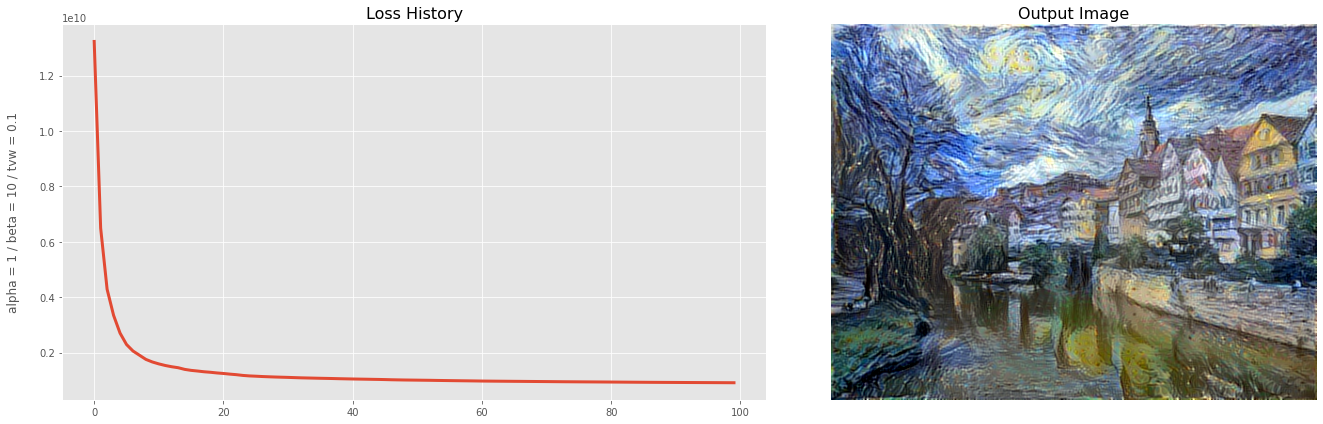

In [22]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

history = list()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    history.append(min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('task7_output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

# Process Summary
print('\n\n')
print(f'Output:')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
image = plt.imread(fname, img)
ax1.plot(range(0,iterations), history, linewidth=3)
ax1.set_ylabel(f'alpha = {content_weight} / beta = {style_weight} / tvw = {total_variation_weight}\n', fontsize=12)
ax1.set_title(f'Loss History', fontsize=16)
ax2.imshow(image)
ax2.set_title(f'Output Image', fontsize=16)
ax2.axis('off')
fig.tight_layout()
fig.savefig(result_prefix / (f'task7_history.png'))
plt.show()

A continuación se adjunta una comparativa de las imágenes seleccionadas y el Output del proceso de Transferencia de Estilo Neuronal:

In [23]:
saved_pngs = [base_image_path, style_reference_image_path, (result_prefix / f'task7_output_at_iteration_{iterations-1}.png').resolve()]
titles = ['Content Image', 'Style Image', 'Output Image']

fig, axs = plt.subplots(1, 3, figsize=(30,10))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for n in range(len(saved_pngs)):
    image = plt.imread(saved_pngs[n])
    axs[n].imshow(image)
    axs[n].set_title(titles[n], fontsize=16)
    axs[n].axis('off')
fig.savefig(result_prefix / ('task7_comparison.png'))
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:

In [24]:
weight_combs = {'comb_1': {'cw': 0.5, 'sw': 20, 'tvw': 0.5},
                'comb_2': {'cw': 1, 'sw': 10, 'tvw': 0.4},
                'comb_3': {'cw': 2, 'sw': 5, 'tvw': 0.3},
                'comb_4': {'cw': 3, 'sw': 1, 'tvw': 0.2},
                'comb_5': {'cw': 4, 'sw': 0.5, 'tvw': 0.1},
                'comb_6': {'cw': 5, 'sw': 0.1, 'tvw': 0.1}}

for comb in weight_combs:
    
    content_weight = weight_combs[comb]['cw']
    style_weight = weight_combs[comb]['sw']
    total_variation_weight = weight_combs[comb]['tvw']

    # Total Loss
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features,
                                                combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                    'block3_conv1', 'block4_conv1',
                    'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :] 
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss = loss + (style_weight / len(feature_layers)) * sl

    loss = loss + total_variation_weight * total_variation_loss(combination_image)

    grads = K.gradients(loss, combination_image)

    outputs = [loss]
    if isinstance(grads, (list, tuple)):
        outputs += grads
    else:
        outputs.append(grads)

    f_outputs = K.function([combination_image], outputs)

    evaluator = Evaluator()

    x = preprocess_image(base_image_path)
    
    # run scipy-based optimization (L-BFGS) over the pixels of the generated image
    # so as to minimize the neural style loss
    history = list()
    start_time = time.time()
    for i in range(iterations):
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                         fprime=evaluator.grads, maxfun=20)
        history.append(min_val)
        if i == 0:
          start_loss = min_val
        else:
          pass

    # save current generated image
    end_loss = min_val
    img = deprocess_image(x.copy())
    fname = result_prefix / (f'task8_output_{str(comb)}.png')
    save_img(fname, img)
        
    end_time = time.time()
        
    # Process Summary
    print(f'Combination: {str(comb)}')
    print('Image saved as', fname)
    print('Style Transfer process completed in %ds' % (end_time - start_time))
    print(f'Losses weights:\n  Content weight (alpha): {content_weight}\n  Style Loss (beta): {style_weight}\n  Total Variation weight: {total_variation_weight}')
    print(f'Start Loss Value: {start_loss}')
    print(f'End Loss Value: {end_loss}')
    print(f'Output:')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    image = plt.imread(fname, img)
    ax1.plot(range(0,iterations), history, linewidth=3)
    ax1.set_ylabel(f'alpha = {content_weight} / beta = {style_weight} / tvw = {total_variation_weight}\n', fontsize=12)
    ax1.set_title(f'Loss History {comb}', fontsize=16)
    ax2.imshow(image)
    ax2.set_title(f'Output Image {comb}', fontsize=16)
    ax2.axis('off')
    fig.tight_layout()
    plt.pause(0.05)
    fig.savefig(result_prefix / (f'task8_history_{str(comb)}.png'))
    print('\n\n')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

A continuación se detalla una comparativa de los resultados del proceso de transferencia de estilo para cada una de las combinaciones de pesos de las losses:

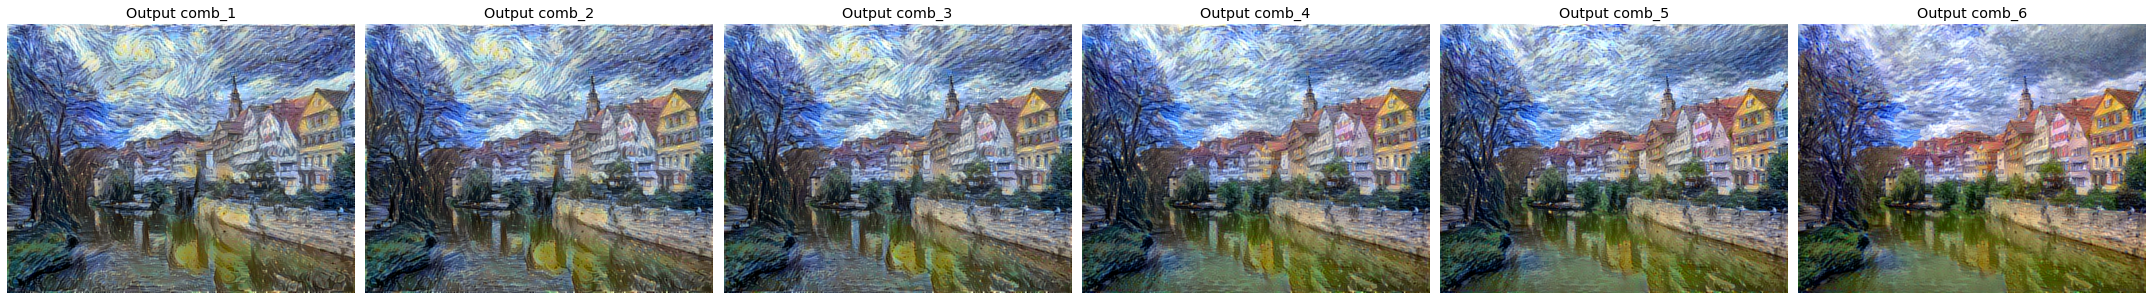

In [25]:
saved_pngs = [f for f in sorted((result_prefix).resolve().iterdir()) if f.stem[0:12] == 'task8_output']

fig, axs = plt.subplots(1, 6, figsize=(30,20))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for n in range(len(saved_pngs)):
    image = plt.imread(saved_pngs[n])
    axs[n].imshow(image)
    axs[n].set_title(f'Output {saved_pngs[n].stem[13:20]}')
    axs[n].axis('off')
fig.savefig(result_prefix / ('task8_comparison_output.png'))
fig.tight_layout()
plt.show()

Cada combinación de pesos registra un incremento progresivo en la relación entre el énfasis de contenido y estilo, partiendo desde una relación de ${0.5 / 20 = 0.025}$ en para la combinación ${comb_1}$ hasta llegar a otra de ${5 / 0.1 = 50}$ para la combinación ${comb_6}$.

Esta variación inversa entre los coeficientes ${\alpha}$ y ${\beta}$ afecta la ponderación de las losses de contenido ($\mathcal{L}_{content}$) y estilo ($\mathcal{L}_style$) respectivamente. Los efectos de estas variaciones se pueden evidenciar en las imágenes generadas, donde las formas y contornos de la imagen que proporcionó el contenido, que inicialmente se observan más difusos por la prevalencia del estilo, van adquiriendo una mayor definición y distinción con cada una de las combinaciones de pesos.

In [26]:
# Weight combinations comparison
saved_pngs = [f for f in sorted((result_prefix).resolve().iterdir()) if f.stem[0:13] == 'task8_history']

fig, axs = plt.subplots(6, 1, figsize=(30,35))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for n in range(len(saved_pngs)):
    image = plt.imread(saved_pngs[n])
    axs[n].imshow(image)
    axs[n].axis('off')
fig.savefig(result_prefix / ('task8_comparison_history_output.png'))
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:

In [27]:
# Imagen para contenido
!wget 'https://upload.wikimedia.org/wikipedia/commons/a/a4/Tiger_in_the_water.jpg'

# Imagen para estilo
!wget 'https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky,_1913_-_Composition_7.jpg'

--2021-01-21 23:12:03--  https://upload.wikimedia.org/wikipedia/commons/a/a4/Tiger_in_the_water.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185971 (182K) [image/jpeg]
Saving to: ‘Tiger_in_the_water.jpg.1’

Tiger_in_the_water. 100%[===================>] 181.61K  --.-KB/s    in 0.07s   

2021-01-21 23:12:04 (2.69 MB/s) - ‘Tiger_in_the_water.jpg.1’ saved [185971/185971]

--2021-01-21 23:12:04--  https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky,_1913_-_Composition_7.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195196 (191K) [image/jpeg]
Saving to: ‘Vassily_Kandinsky,_1913_-_Compo

Model loaded.
Start of iteration 0
Image saved as output/task9_output_at_iteration_0.png
Iteration 0 completed in 7s
Start of iteration 1
Image saved as output/task9_output_at_iteration_1.png
Iteration 1 completed in 5s
Start of iteration 2
Image saved as output/task9_output_at_iteration_2.png
Iteration 2 completed in 5s
Start of iteration 3
Image saved as output/task9_output_at_iteration_3.png
Iteration 3 completed in 5s
Start of iteration 4
Image saved as output/task9_output_at_iteration_4.png
Iteration 4 completed in 5s
Start of iteration 5
Image saved as output/task9_output_at_iteration_5.png
Iteration 5 completed in 5s
Start of iteration 6
Image saved as output/task9_output_at_iteration_6.png
Iteration 6 completed in 5s
Start of iteration 7
Image saved as output/task9_output_at_iteration_7.png
Iteration 7 completed in 5s
Start of iteration 8
Image saved as output/task9_output_at_iteration_8.png
Iteration 8 completed in 5s
Start of iteration 9
Image saved as output/task9_output_at_

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:1458: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ext != 'png':


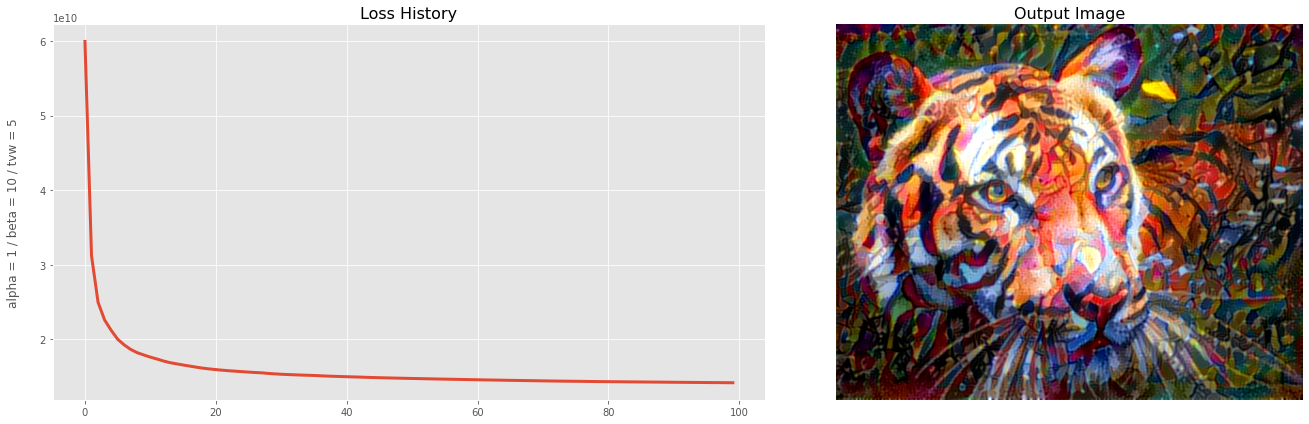

In [28]:
content_weight = 1
style_weight = 10
total_variation_weight = 5

base_image_path = Path("./Tiger_in_the_water.jpg")
style_reference_image_path = Path("./Vassily_Kandinsky,_1913_-_Composition_7.jpg")

# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
# Total Loss
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

loss = loss + total_variation_weight * total_variation_loss(combination_image)

grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

evaluator = Evaluator()

x = preprocess_image(base_image_path)
    
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
history = list()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    history.append(min_val)
    
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('task9_output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

elapsed = time.time()        
# Process Summary
print('\n\n')
print('Style Transfer process completed in %ds' % (elapsed - start_time))
print(f'Losses weights:\n  Content weight (alpha): {content_weight}\n  Style Loss (beta): {style_weight}\n  Total Variation weight: {total_variation_weight}')
print(f'Start Loss Value: {history[0]}')
print(f'End Loss Value: {history[-1]}')
print(f'Output:')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
image = plt.imread(fname, img)
ax1.plot(range(0, iterations), history, linewidth=3)
ax1.set_ylabel(f'alpha = {content_weight} / beta = {style_weight} / tvw = {total_variation_weight}\n', fontsize=12)
ax1.set_title(f'Loss History', fontsize=16)
ax2.imshow(image)
ax2.set_title(f'Output Image', fontsize=16)
ax2.axis('off')
fig.tight_layout()
fig.savefig(result_prefix / (f'task9_history.png'))
plt.show()

A continuación se adjunta una comparativa de las imágenes seleccionadas y el Output del proceso de Transferencia de Estilo Neuronal:

In [29]:
saved_pngs = [base_image_path, style_reference_image_path, (result_prefix / f'task9_output_at_iteration_{iterations-1}.png').resolve()]
titles = ['Content Image', 'Style Image', 'Output Image']

fig, axs = plt.subplots(1, 3, figsize=(30,10))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for n in range(len(saved_pngs)):
    image = plt.imread(saved_pngs[n])
    axs[n].imshow(image)
    axs[n].set_title(titles[n], fontsize=16)
    axs[n].axis('off')
fig.savefig(result_prefix / ('task9_comparison.png'))
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.